In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook,curdoc, show,output_file
from bokeh.models import ColumnDataSource, FactorRange,Grid, HBar, LinearAxis, Plot,LabelSet,Legend
from bokeh.core.properties import value
from bokeh.transform import factor_cmap,dodge
from bokeh.palettes import Spectral10
from bokeh.models import HoverTool
from bokeh.models import Select, TextInput
from bokeh.layouts import column,row


# select a palette
from bokeh.palettes import Spectral3
from bokeh.palettes import Category20b_13 as palette
from bokeh.palettes import Category20b_14 as palette2
# itertools handles the cycling
import itertools  
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn import tree

sns.set(style='darkgrid', palette='muted', color_codes=True)



# Magic command useful for jupyter notebook
%matplotlib inline

# Set plot size. 
plt.rcParams['figure.figsize'] = [13, 6]

# Set font size
plt.rcParams.update({'font.size': 22})

## Pre processing

In [2]:
df_crash = pd.read_csv('data/crash_clean.csv')
df_vehicle = pd.read_csv('data/vehicle_clean.csv')
df_people = pd.read_csv('data/people_clean.csv')

In [3]:
df_crash['CRASH DATE'] = pd.to_datetime(df_crash['CRASH DATE'])
df_crash['CRASH TIME'] = pd.to_datetime(df_crash['CRASH TIME']) 

### Heatmap plots 

In [4]:
df_crash.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,1,2016-06-01,2020-05-01 13:54:00,QUEENS,40.655834,-73.839035,CROSS BAY BOULEVARD,161 AVENUE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,3453947,PASSENGER VEHICLE,PASSENGER VEHICLE
1,4,2016-06-03,2020-05-01 17:15:00,QUEENS,40.665558,-73.729850,HOOK CREEK BOULEVARD,SUNRISE HIGHWAY,0,0,...,0,0,0,0,0,Unspecified,Unspecified,3455499,PASSENGER VEHICLE,PASSENGER VEHICLE
2,7,2016-05-12,2020-05-01 03:35:00,MANHATTAN,40.738316,-73.987730,EAST 20 STREET,PARK AVENUE SOUTH,2,0,...,0,0,0,2,0,Traffic Control Disregarded,Unspecified,3439699,PASSENGER VEHICLE,PASSENGER VEHICLE
3,14,2016-05-18,2020-05-01 21:15:00,QUEENS,40.768906,-73.736960,NORTHERN BOULEVARD,CORNELL LANE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,3452101,PASSENGER VEHICLE,PASSENGER VEHICLE
4,17,2016-05-24,2020-05-01 09:03:00,STATEN ISLAND,40.562130,-74.118190,HYLAN BOULEVARD,OAK AVENUE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,3452710,PASSENGER VEHICLE,PASSENGER VEHICLE


In [6]:
df_crash.dtypes

Unnamed: 0                                int64
CRASH DATE                       datetime64[ns]
CRASH TIME                       datetime64[ns]
BOROUGH                                  object
LATITUDE                                float64
LONGITUDE                               float64
ON STREET NAME                           object
CROSS STREET NAME                        object
NUMBER OF PERSONS INJURED                object
NUMBER OF PERSONS KILLED                 object
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
COLLISION_ID                              int64
VEHICLE TYPE CODE 1                      object
VEHICLE TYPE CODE 2                     

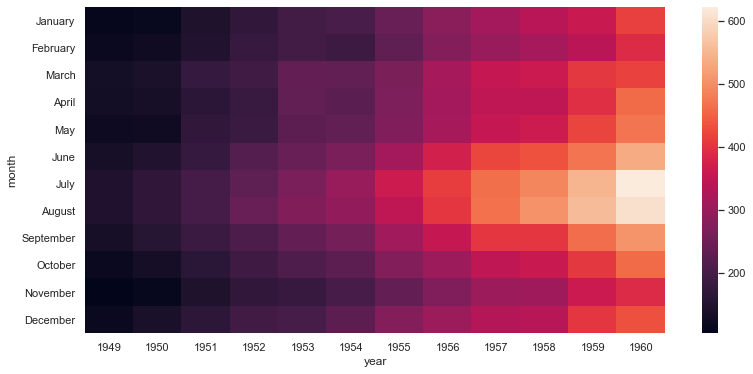

In [7]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)


In [8]:
hmap = df_crash.groupby([df_crash['CRASH DATE'].dt.month, df_crash['CRASH DATE'].dt.year])
hmap=hmap.size().unstack()

In [9]:
hmap = hmap.rename_axis(index={'CRASH DATE': 'Month'},columns={'CRASH DATE': 'Year'}).fillna(0).astype(int)

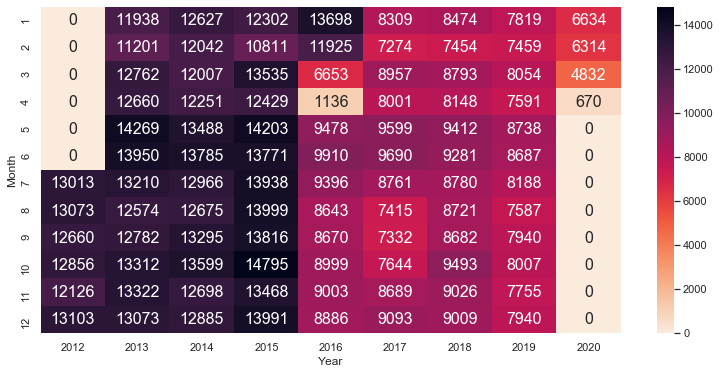

In [10]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(hmap,annot=True,fmt="d",annot_kws={"size": 16},cmap = cmap)

In [11]:
#sns.choose_light_palette() 

## Inteactive bokeh plot of dangerous intersections. 

In [5]:
df_crash['ON STREET NAME'] = df_crash['ON STREET NAME'].str.strip()

In [6]:
total =df_crash.groupby('ON STREET NAME').size()

In [7]:
obj = df_crash.groupby(['ON STREET NAME','BOROUGH'], as_index = False).size()

In [18]:
obj=pd.DataFrame(obj)
obj

0
ON STREET NAME    BOROUGH         
                  BRONX          1
                  BROOKLYN       4
                  MANHATTAN      1
                  QUEENS         3
                  STATEN ISLAND  2
...                             ..
queens plaza east QUEENS         1
quintard st       STATEN ISLAND  1
south avenue      Unspecified    1
west 79th street  MANHATTAN      1
williams avenue   BROOKLYN       1

[10082 rows x 1 columns]

In [8]:
obj.loc[:, 'QUEENS']

ON STREET NAME
                       3
1 STREET              32
10 AVENUE             27
10 STREET            144
100 AVENUE            84
                    ... 
central avenue         1
colden street          1
holly ave              1
merrick boulevard      2
queens plaza east      1
Length: 2125, dtype: int64

In [9]:
largest = total[total>4000].sort_values(ascending = True)

In [10]:
largest.values

array([ 4100,  4138,  4300,  4380,  4468,  4489,  4536,  4563,  4665,
        5287,  5581,  6905,  6930,  7059,  7119,  8568,  9187, 11368,
       12530], dtype=int64)

In [11]:
street = [str(elem).rstrip() for elem in largest.index.to_list()]
street

['NOSTRAND AVENUE',
 'HILLSIDE AVENUE',
 'WOODHAVEN BOULEVARD',
 '1 AVENUE',
 '10 AVENUE',
 'HYLAN BOULEVARD',
 '7 AVENUE',
 '8 AVENUE',
 'JAMAICA AVENUE',
 '5 AVENUE',
 'BRUCKNER BOULEVARD',
 '2 AVENUE',
 'FLATBUSH AVENUE',
 'QUEENS BOULEVARD',
 'LINDEN BOULEVARD',
 'NORTHERN BOULEVARD',
 '3 AVENUE',
 'ATLANTIC AVENUE',
 'BROADWAY']

In [12]:
output_notebook()

Loading BokehJS ...

In [19]:
fruits = street
years = largest.values

data = {'fruits' : street,
        'count'   : largest.values}

source = ColumnDataSource(data=data)

p = figure(y_range=FactorRange(factors=fruits), x_range=(0, 13000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p.hbar(y='fruits', right='count', height=0.7, source=source)

#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")


p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
show(p)

In [20]:
obj

0
ON STREET NAME    BOROUGH         
                  BRONX          1
                  BROOKLYN       4
                  MANHATTAN      1
                  QUEENS         3
                  STATEN ISLAND  2
...                             ..
queens plaza east QUEENS         1
quintard st       STATEN ISLAND  1
south avenue      Unspecified    1
west 79th street  MANHATTAN      1
williams avenue   BROOKLYN       1

[10082 rows x 1 columns]

In [20]:
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.plotting import figure, output_file, show

fruits = street
years = largest.values
output_file('test.html')

data = {'fruits' : street,
        'count'   : largest.values}

source = ColumnDataSource(data=obj)

p = figure(y_range=FactorRange(factors=fruits), x_range=(0, 13000), plot_width=800,plot_height=400,title="Total recorded accidents ")
# Add circles to the plot
p.hbar(y='fruits', right='count', height=0.7, source=source)

callback = CustomJS(args=dict(source=source), code="""
    data = source.data;
    f = cb_obj.value; 
    if (f == "Queens") {
        data['x'] = data.x_50_free;
        data['y'] = data.y_50_free;
    } else if (f == "") {
        data['x'] = data.x_100_free;
        data['y'] = data.y_100_free;
    }
    source.change.emit();
""")

select = Select(title="Borough:", value="", options=["Queens",'Other', 'Other'])
select.js_on_change('value', callback)   

layout = column(select, p)

show(layout)

## NY MAP





In [17]:
import pandas as pd
import random
from datetime import timedelta

df = pd.DataFrame({'base' : ["2017-01-01" for t in range(10000)],
    'Date' : [random.randint(0, 1035) for t in range(10000)], 
                   'Sales' : [random.random() for t in range(10000)]})
df['base'] = pd.to_datetime(df['base'])
df["Date2"] = df.apply(lambda x: x["base"] + timedelta(days=x['Date']), axis=1)
df.drop(['base', 'Date'], axis=1, inplace=True)

from bokeh.models.widgets import Slider
from bokeh.layouts import widgetbox, column
from bokeh.models import Slider, ColumnDataSource, CustomJS
from bokeh.plotting import figure, curdoc
from bokeh.core.properties import value
from bokeh.models.ranges import FactorRange
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import ColumnDataSource, CDSView, IndexFilter, BooleanFilter, HoverTool

df.set_index('Date2', inplace=True)
df['month'] = df.index.month
df['year'] = df.index.year
df['day'] = df.index.day
source1=df.groupby(['year','month','day'], as_index = False).sum()
source = source1[source1['year']== 2017]
sourcex = source[source['month'] ==1]
Overall=ColumnDataSource(source)
Curr=ColumnDataSource(sourcex)
boolinit = source['month']==1
view = CDSView(source=Overall, filters=[BooleanFilter(boolinit)])
hover3 = HoverTool(tooltips = [('day', '@day'),('Sales','@{Sales}{0,0}')],
                   formatters = {'day': 'datetime','Sales': 'numeral'})

p =  figure(title='YEARLY SALES',  plot_width=600, plot_height=400, min_border=3,
tools = [hover3,'box_zoom','wheel_zoom', 'pan','reset'],  
toolbar_location="above")

r = p.vbar(x='day', top='Sales', width=0.2, color='#e8bc76', source=Curr)
p.xaxis.axis_label = 'Day'
p.xaxis.axis_label_text_font_style = 'normal'
p.xaxis.axis_label_text_font_size = '12pt'


callback = CustomJS(args=dict(source=Overall, sc=Curr), code="""       
    var f = slider.value;
    sc.data['day'] = [];
    sc.data['ExtendedPrice'] = [];
    for (var i = 0; i <= source.get_length(); i++){
      if (source.data['month'][i] == f){
        sc.data['day'].push(source.data['day'][i])
        sc.data['ExtendedPrice'].push(source.data['ExtendedPrice'][i])
      }
    }
    sc.change.emit();
""")
slider = Slider(start=1, end=12, value=1, step=1, title="Month")
slider.js_on_change('value', callback)

layout = column(slider, p)

#fig.view.filters[0].booleans = indices
show(layout)

In [18]:
conda list

# packages in environment at C:\Users\Magnu\Anaconda3:
Note: you may need to restart the kernel to use updated packages.
#
# Name                    Version                   Build  Channel
_anaconda_depends         2019.03                  py37_0  
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
alabaster                 0.7.12                   py37_0  
anaconda                  custom                   py37_1  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.7                    py37_0  
anaconda-project          0.8.4                      py_0  
argh                      0.26.2                   py37_0  
ase                       3.19.0                     py_0    conda-forge
asn1crypto                1.3.0                    py37_0  
astroid                   2.3.3                    py37_0  
astropy                   4.0              py37he774522_0  
atomicwrites              1.3.0                    py37_1  
attrs            

nbconvert                 5.6.1                    py37_0  
nbformat                  5.0.4                      py_0  
networkx                  2.4                        py_0  
nltk                      3.4.5                    py37_0  
nose                      1.3.7                    py37_2  
notebook                  6.0.3                    py37_0  
numba                     0.48.0           py37h47e9c7a_0  
numexpr                   2.7.1            py37h25d0782_0  
numpy                     1.18.1           py37h93ca92e_0  
numpy-base                1.18.1           py37hc3f5095_1  
numpydoc                  0.9.2                      py_0  
olefile                   0.46                     py37_0  
openpyxl                  3.0.3                      py_0  
openssl                   1.1.1f               hfa6e2cd_0    conda-forge
packaging                 20.3                       py_0  
pandas                    1.0.3            py37h47e9c7a_0  
pandoc                    2